# Sistema de Recomendacion de Peliculas.

En esta etapa usaremos nuestro dataframe ya analizado para crear un sistema de recomendacion de peliculas basado en el resumen de cada pelicula. nuestro sistema recomendara las 5 peliculas mas parecidas por orden de votacion.

Primero importemos nuestras herramientas

In [2]:
import itertools
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [3]:
#traigamos el dataset preparado
df = pd.read_csv('data/movies_ml.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print(df.shape)
df.head(4)

(2798, 4)


,title,vote_average,vote_count,overview
0,Dilwale Dulhania Le Jayenge,9.1,661.0,"Raj is a rich, carefree, happy-go-lucky second..."
1,The Shawshank Redemption,8.5,8358.0,Framed in the 1940s for the double murder of h...
2,The Godfather,8.5,6024.0,"Spanning the years 1945 to 1955, a chronicle o..."
3,Your Name.,8.5,1030.0,High schoolers Mitsuha and Taki are complete s...


In [4]:
df.overview = df.overview.apply(lambda x: x.lower())

Observamos que solo 1888 peliculas estaremos trabajando, esta drastica reduccion personalmente la hice ya que no recomendaria peliculas que tengan menos de 300 votos a un cliente potencial, ya que podria no ser realmente buena o parecida.

Filtremos las stopwords para nuestro procesamiento del lenguaje

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")
    filtrar.append("The")
    filtrar.append("In")
    filtrar.append("A")

Tokenizemos y filtremos las palabras de nuestra columna overview

In [6]:
lista = []
for i in range(df.shape[0]):
    titular = df.iloc[i, -1]
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
    titular = [word for word in titular if word not in filtrar]

    lista.append(titular)


In [7]:
lista = list(itertools.chain(*lista))
lista[0:10]

['raj',
 'rich',
 'carefree',
 'happy',
 'go',
 'lucky',
 'second',
 'generation',
 'nri',
 'simran']

In [8]:
freq_peliculas =nltk.FreqDist(lista)
freq_peliculas

FreqDist({'life': 483, 'world': 406, 'one': 383, 'young': 339, 'man': 323, 'two': 310, 'must': 306, 'family': 301, 'find': 285, 'love': 239, ...})

Creemos un dataframe con las palabras y su frecuencia

In [9]:
palabras_peliculas = pd.DataFrame(list(freq_peliculas.items()), columns=['palabra', 'frecuencia'])
palabras_peliculas.head()

,palabra,frecuencia
0,raj,2
1,rich,28
2,carefree,9
3,happy,26
4,go,102


In [10]:
palabras_peliculas.sort_values('frecuencia', ascending=False, inplace=True)
palabras_peliculas.head(15)

,palabra,frecuencia
46,life,483
223,world,406
106,one,383
229,young,339
190,man,323
118,two,310
119,must,306
32,family,301
145,find,285
29,love,239


In [11]:
palabras_peliculas.reset_index(drop=True, inplace=True)

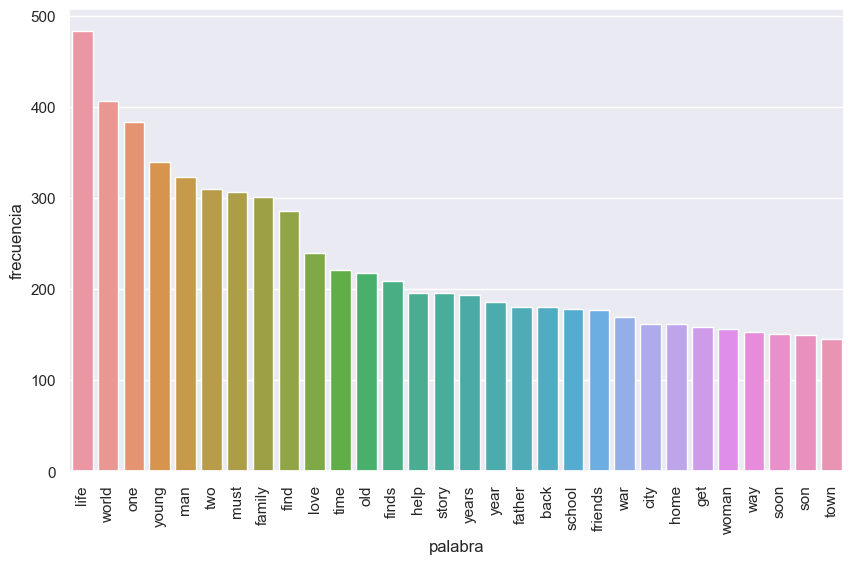

In [12]:
plt.figure(figsize=(10,6))
plot = sns.barplot(x = palabras_peliculas.iloc[:30].palabra, y=palabras_peliculas.iloc[:30].frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [13]:
#Instanciamos el lemmatizador
lemmatizer = WordNetLemmatizer()

Creamos una funcion para hacer el preprocesamiento.

In [14]:
def preprocesamiento(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-Z]', ' ', texto)
    tokens = texto.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    texto_procesado = ' '.join(tokens)
    return texto_procesado

In [15]:
df['overview'] = df['overview'].apply(preprocesamiento)


Vectorizamos y entrenamos.

In [16]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['overview'])

Creamos la matriz de similitud.

In [17]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [18]:
import joblib

Extraemos la matriz en formato pickle para trabajarla en nuestra api de manera mas eficiente.

In [19]:
joblib.dump(similarity_matrix, 'pickle/similarity_matrix.pkl')

['pickle/similarity_matrix.pkl']

In [20]:
def get_recommendations(nombre_pelicula, similarity_matrix, num_recommendations=5):
    movie_index = df[df['title'] == nombre_pelicula].index[0]
    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_scores = similarity_scores[1:num_recommendations+1]
    top_movie_indices = [score[0] for score in top_scores]
    top_movies = df['title'].iloc[top_movie_indices]
    dicc = {}
    for i, v in enumerate(top_movies.values):
        dicc[i + 1] = v
    return dicc

In [21]:
recommended_movies = get_recommendations('Toy Story', similarity_matrix)
print(recommended_movies)

{1: 'Toy Story 3', 2: 'Toy Story 2', 3: 'The 40 Year Old Virgin', 4: 'Rebel Without a Cause', 5: 'Man on the Moon'}


El Resultado me es perfectamente viable para lo que se requiere del proyecto. por lo que ya estamos listos para deployarlo. 

Gracias por acompañarme en mi primer proyecto! espero sea de su agrado.

In [22]:
df.to_csv('data/df_ml.csv')